In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [2]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
data.shape

(4340, 8)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


In [5]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [6]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
X.dtypes

name            object
year             int64
km_driven        int64
fuel            object
seller_type     object
transmission    object
owner           object
dtype: object

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле(числителе мы проходимся по объектам из каждой категории, смотрим, сколько из них класса +1(хотя у нас задача регрессии) и делим на общее количество объектов данной категории):

$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]} + C * \epsilon
$$

Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [8]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        
        ### Your code is here
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):

        ### Your code is here
        
        X_fit = X.copy()
        y_fit = y.copy()
        
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        
        
        
        self.dict_of_means = {col: X_with_target.groupby(col)['selling_price'].mean() + 0.006 * np.random.normal(loc=0.0, scale=1.0, size=1)[0] for col in self.categorical}

        return self
        
    def transform(self, df):        
        df_ = df.copy()
        for col in self.categorical:
            df_[col] = df_[col].map(self.dict_of_means[col])
            df_[col] = df_[col].fillna(0)
        return df_

In [10]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

test.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
2761,13.676757,13.549194,15000,13.085954,12.611658,12.643381,12.959126
3210,13.049908,12.925205,70000,13.085954,12.611658,12.643381,12.446379
2606,13.132308,12.623292,90000,13.085954,12.611658,12.643381,12.959126
1030,12.394349,13.131873,41000,12.450179,13.140882,12.643381,12.959126
3942,13.387774,12.925205,71318,13.085954,13.140882,12.643381,12.959126


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [11]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [12]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)
rmsle = []

### Your code is here
for depth in max_depth_list:
    pipe = Pipeline([('mean_target_enc', 
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                      
                     ('decision_tree',
                      DecisionTreeRegressor(max_depth=depth))
                     ])
    
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    rmsle += [mse(y_test, test_preds, squared = True)]


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

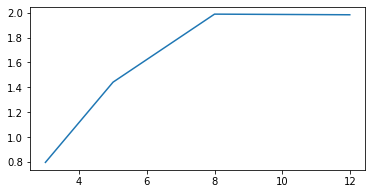

In [13]:
fig = plt.figure()
fig.set_size_inches(6, 3)

sns.lineplot(max_depth_list, rmsle)

In [14]:
np.random.seed(1)
rmsle2 = []

### Your code is here
for samples_split_list in min_samples_split_list:
    pipe = Pipeline([('mean_target_enc', 
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                      
                     ('decision_tree',
                      DecisionTreeRegressor(min_samples_split=samples_split_list))
                     ])
    
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    rmsle2 += [mse(y_test, test_preds, squared = True)]

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

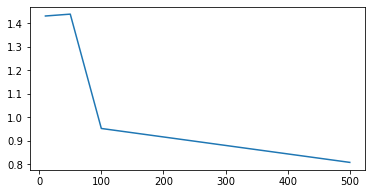

In [15]:
fig = plt.figure()
fig.set_size_inches(6, 3)

sns.lineplot(min_samples_split_list, rmsle2)

In [16]:
np.random.seed(1)
rmsle3 = []

### Your code is here
for leaf_nodes in max_leaf_nodes_list:
    pipe = Pipeline([('mean_target_enc', 
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                      
                     ('decision_tree',
                      DecisionTreeRegressor(max_leaf_nodes=leaf_nodes))
                     ])
    
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    rmsle3 += [mse(y_test, test_preds, squared = True)]

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

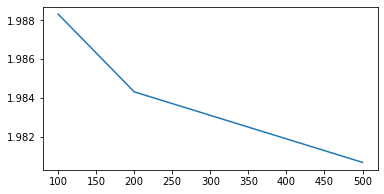

In [17]:
fig = plt.figure()
fig.set_size_inches(6, 3)

sns.lineplot(max_leaf_nodes_list, rmsle3)

In [18]:
rmsle4 = []
for impur in min_impurity_decrease_list:
    pipe = Pipeline([('mean_target_enc', 
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
                      
                     ('decision_tree',
                      DecisionTreeRegressor(min_impurity_decrease=impur))
                     ])
    
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    rmsle4 += [mse(y_test, test_preds, squared = True)]

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

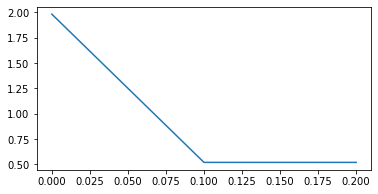

In [19]:
fig = plt.figure()
fig.set_size_inches(6, 3)

sns.lineplot(min_impurity_decrease_list, rmsle4)

In [20]:
min(rmsle).round(3), min(rmsle2).round(3), min(rmsle3).round(3), min(rmsle4).round(3) 

(0.797, 0.808, 1.981, 0.52)

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

selector = KFold(n_splits = 4, shuffle = True, random_state = 33)

### Your code is here
search = GridSearchCV(pipe, 
                     param_grid, 
                     cv = selector,
                     scoring = 'neg_mean_squared_error')

search.fit(X_train, y_train)





GridSearchCV(cv=KFold(n_splits=4, random_state=33, shuffle=True),
             estimator=Pipeline(steps=[('mean_target_enc',
                                        MeanTargetEncoderNoise(categorical=['name',
                                                                            'year',
                                                                            'fuel',
                                                                            'seller_type',
                                                                            'transmission',
                                                                            'owner'],
                                                               numeric=['km_driven'])),
                                       ('decision_tree',
                                        DecisionTreeRegressor(min_impurity_decrease=0.2))]),
             param_grid={'decision_tree__max_depth': [3, 5, 8, 12],
                         'decision_tree__max_lea

In [22]:
search.best_params_

{'decision_tree__max_depth': 3,
 'decision_tree__max_leaf_nodes': 200,
 'decision_tree__min_impurity_decrease': 0.15,
 'decision_tree__min_samples_split': 50}

In [23]:
search.score(X_test, y_test)

-0.5204871413036686